In [26]:
import pickle
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch import FloatTensor 
from model.dkt import DKT
from model.sakt import SAKT
from model.dkvmn import DKVMN
from model.deep_irt import DEEPIRT


from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from preprocess.data_preprocess_deeplearning import preprocess_difficulty, q_seq_r_seq, match_seq_len


In [27]:
import sys 
from train_deeplearning import main 
import matplotlib.cm as cm
colors = ["r","g","b","c","m","y"]

def run_model(model_name):
    auc_array, loss_array, state = main(model_name)
    #plot auc 
    fig = plt.figure(facecolor=(1,1,1))    
    plt.plot(np.arange(1,10+1), auc_array)
    plt.title("{}_IRT".format(model_name))
    plt.xlabel("Epoch")
    plt.ylabel("Test-AUC")
    fig.savefig("model_result/{}_IRT/(using GRU)AUC_{}.png".format(model_name, auc_array[-1]), bbox_inches='tight')
    plt.show()

    #plot loss 
    fig = plt.figure(facecolor=(1,1,1))    
    plt.plot(np.arange(1,10+1), loss_array)
    plt.title("{}_IRT".format(model_name))
    plt.xlabel("Epoch")
    plt.ylabel("Test-LOSS")
    fig.savefig("model_result/{}_IRT/(using GRU)LOSS_{}.png".format(model_name, loss_array[-1]), bbox_inches='tight')
    plt.show()
    
    with open('best_state/best_state.txt','a') as f:
        f.write("")
        f.write('\n')
        f.write(state)
        f.write('\n')
        
    print(state)
    return state

   

In [28]:
def prob_kc_target(model_name, target, state):
    with open(".datasets/df_difficulty_tag.pkl", "rb") as f:
        df = pickle.load(f)

    df_for_oneuser = df[df["userSeq"] == target]
    q_oneuser, r_oneuser = q_seq_r_seq_oneuser(df_for_oneuser, model_name)
    q_seq, r_seq, t_seq, d_seq, m_seq = match_seq_len(model_name, q_oneuser,r_oneuser)
    q_seq, r_seq, t_seq, d_seq, m_seq = np.array(q_seq), np.array(r_seq), np.array(t_seq), np.array(d_seq), np.array(m_seq)
    
    with open(".datasets/q_list_{}.pkl".format(model_name), "rb") as f:
        q_list = pickle.load(f)

    # load the model 
    device = torch.device("cpu")

    if model_name == "SAKT":
        model = SAKT(len(q_list), 30, 100, 5, 0.2) 
    elif model_name == "DKVMN":
        model = DKVMN(len(q_list), 50, 50, 20)
    elif model_name == "DKT":
        model = DKT(200, len(q_list)) 
        
    model.load_state_dict(torch.load(state, map_location = device))
    # with open(".datasets/dkvmn_mvs.pkl", "rb") as f:
    #     M_vs = pickle.load(f)
    user_state = []
    one_user_len = len(q_oneuser[0])
    # print("length of q_oneuser: ", one_user_len)
    # print("length of q_seq[0]: ", len(q_seq))
    # print("length of q_seq[1]: ", len(q_seq[0]))
    # print(q_seq)
    if model_name == "DKT":
        #DKT (try new)
        # p = model.forward(q_seq, r_seq)
        # print(p.size()[0]," and ", p.size()[1])
        # p = p.reshape(1, p.size()[0]*p.size()[1], p.size()[2])
        # ppp = [p[0][i].detach().numpy() for i in range(0,one_user_len)]
        # return ppp

        #DKT (error)
        q_oneuser, r_oneuser = np.array(q_oneuser), np.array(r_oneuser)
        model.eval()
        
        p = model.get_knowledge_state(q_oneuser.T, r_oneuser.T)
        ppp = [pp.detach().numpy() for pp in p]
        ppp = np.array(ppp)
        return ppp
    elif model_name == "SAKT":
        # SAKT
        # iterate through user's q_oneuser and r_oneuser and get the probability 
        user_state = []
        for q, r in zip(q_oneuser[0], r_oneuser[0]):
            p = model.get_knowledge_state(q, r)
            p = [pp.detach().numpy() for pp in p]
            user_state.append(p)
        user_state = np.array(user_state)
        # print("shape of user_state is ", np.shape(np.array(user_state))) 
        return user_state


In [29]:
def q_seq_r_seq_oneuser(df, model_name):
    with open(".datasets/q2idx_{}.pkl".format(model_name), "rb") as f:
        q2idx = pickle.load(f)
    q_seq, r_seq,  = [], []
    q_temp, r_temp = [], []
    for i, row in df.iterrows():
        q_temp.append(q2idx[row["difficulty"]])
        r_temp.append(row["isCorrect"])
    q_seq.append(q_temp)
    r_seq.append(r_temp)   
    return q_seq, r_seq

In [30]:
def draw_user_state(model_name, userseq, user_state):
    fig = plt.figure(figsize=[30, 15], facecolor="white")
    user_state = user_state.T 
    print("shape of user_state: ", np.shape(user_state))
    
    sigmoid = lambda x: 1/(1+np.exp(-x))
    # user_state = user_state.mean(axis=0)    #when using mean
    # user_state = sigmoid(user_state)        #when using mean

    user_state = sigmoid(user_state)    #when not using mean
    # user_state = user_state.mean(axis=0)
    print("shape of user_state: ", np.shape(np.array(user_state)))

    with open(".datasets/user_solved_problem.pkl", "rb") as f:
        user_solved_problem = pickle.load(f)
    target_problems = user_solved_problem[userseq]
    with open(".datasets/df_difficulty_tag.pkl", "rb") as f:
        df = pickle.load(f)

    target_p, target_r = [], []
    for t in target_problems: 
        df_temp = df.loc[df['question_id'] == t, 'difficulty']
        df_temp2 = df[df["userSeq"] == userseq]
        df_temp2 = df_temp2[df_temp2['question_id'] == t]
        response = df_temp2["isCorrect"].values[0]
        difficulty = df_temp.values[0]
        target_p.append(difficulty)
        target_r.append(response)

    show_labels = []
    for p,r in zip(target_p, target_r):
        # print(r)
        if r == 1:
            res = 'o'
        else:
            res = 'x'
        label = str(p)+"("+res+')'
        show_labels.append(label)
    print(np.shape(np.array([show_labels]).T))
    print(np.shape(np.array(user_state).T))

    # solved_info = np.vstack(([np.array(show_labels).T], [np.array(user_state).T]))  #when using mean
    solved_info = np.concatenate((np.array([show_labels]).T, np.array(user_state).T), axis = 1)  #when not using mean
    
    # solved_info = pd.DataFrame(solved_info.T, columns=['correct/wrong', 'understanding'])
    pd.DataFrame(solved_info).to_csv("model_result/pred/{}/{}_{}_solved.csv".format(model_name,userseq,model_name))

    plt.xticks(np.arange(1,len(target_p)+1, step = 1), show_labels, fontsize = 10, rotation = 20 )
    plt.pcolormesh(user_state[:,:50], cmap="Reds", vmin = 0, vmax = 1)    #when not using mean
    # plt.pcolormesh([user_state[:50]], cmap="Reds", vmin = 0, vmax = 1)      #when using mean
    plt.colorbar()
    plt.show()
    fig.savefig("model_result/{}_student_state_{}mean.png".format(userseq, model_name)) 
    return solved_info

# run the whole process here

24
(24, 101)
size of q:  (2418, 1)
size of x:  torch.Size([2418, 1])
size of x_t:  torch.Size([2418, 1, 200])
size of y: 
here is the hidden_state:
tensor([[[-0.9511, -0.7092,  0.7934, -0.9854,  0.9355, -0.5309,  0.7746,
           0.1439,  0.9426,  0.7943,  0.5245, -0.9526, -0.9344, -0.9373,
          -0.9569, -0.9620, -0.2375, -0.4323, -0.9629, -0.7966,  0.9102,
          -0.8893, -0.4858, -0.7139, -0.7376,  0.7153,  0.9878,  0.4969,
          -0.9199, -0.7153,  0.8508,  0.9131, -0.5238, -0.8340, -0.8434,
           0.8533, -0.5142, -0.9970,  0.8896,  0.9462, -0.7920,  0.9843,
           0.9381, -0.3728,  0.9253, -0.8855, -0.5766,  0.9733, -0.5834,
          -0.9855,  0.6809,  0.6248, -0.1018,  0.4023,  0.9727,  0.7542,
           0.9725, -0.9229,  0.8433,  0.8581,  0.9816,  0.9128,  0.8200,
          -0.5638, -0.8233, -0.9982,  0.3766,  0.9295, -0.6698,  0.9802,
           0.6783,  0.9458,  0.9821,  0.9036,  0.9004,  0.9726,  0.6126,
           0.5093,  0.1217,  0.0386,  0.8898,  0.

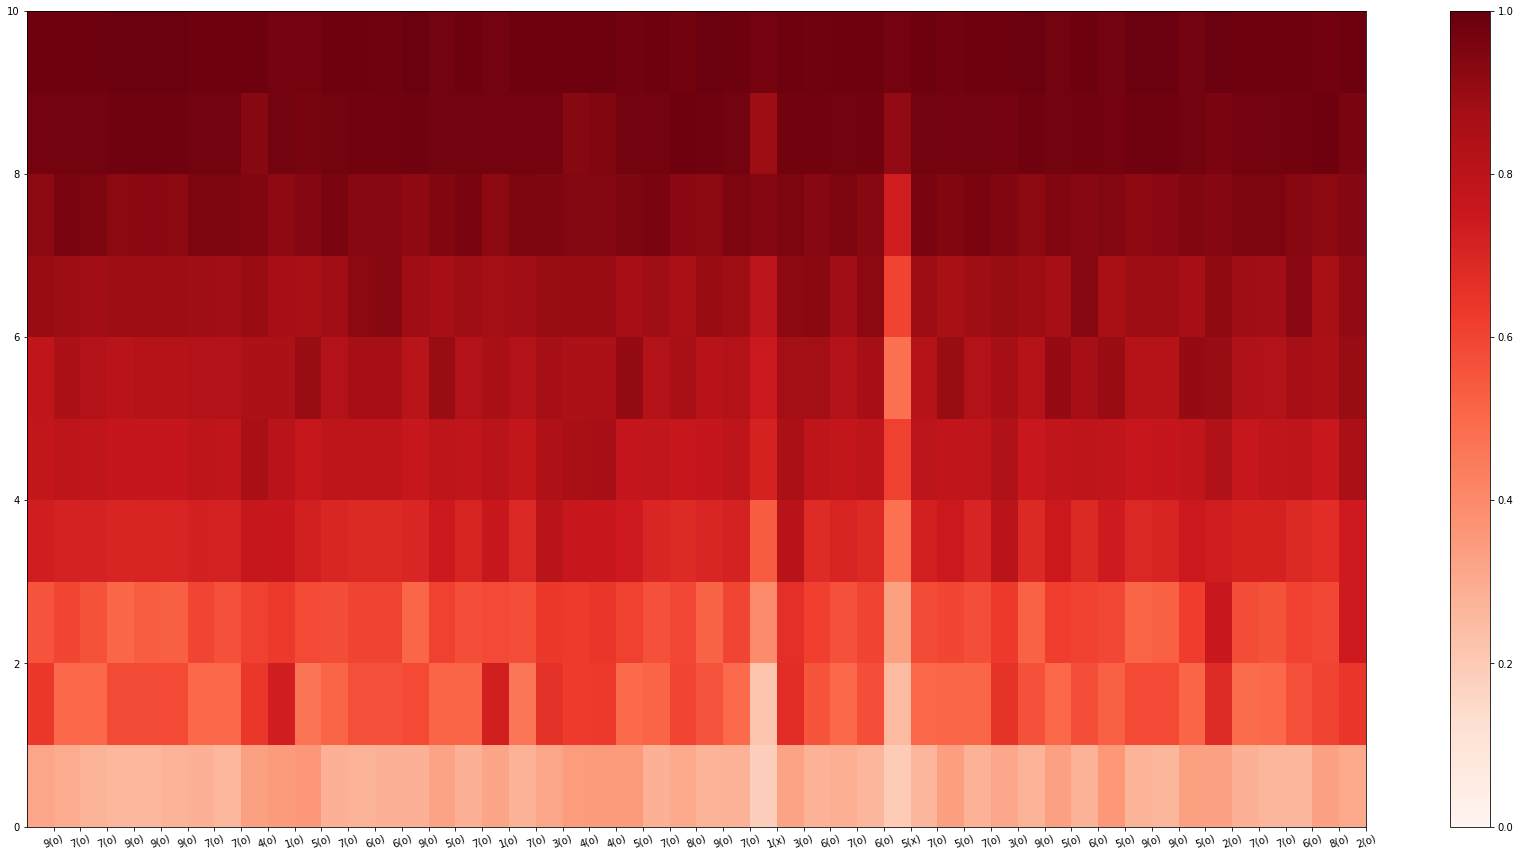

20
(20, 101)
size of q:  (2019, 1)
size of x:  torch.Size([2019, 1])
size of x_t:  torch.Size([2019, 1, 200])
size of y: 
here is the hidden_state:
tensor([[[-0.9566, -0.9528,  0.9096, -0.9845,  0.9393,  0.7245,  0.8567,
          -0.0155,  0.9376,  0.9821, -0.6709, -0.7027, -0.9216, -0.9672,
          -0.9823, -0.9915, -0.8263,  0.1062, -0.9495, -0.8959,  0.9839,
          -0.9186, -0.9691,  0.0329, -0.9077,  0.9505,  0.9685,  0.6586,
          -0.9307,  0.3597, -0.5919,  0.8505, -0.9243, -0.9556, -0.9515,
           0.9445, -0.7927, -0.9098, -0.5014,  0.9523, -0.7340,  0.9910,
           0.9580, -0.8691,  0.0452,  0.4980,  0.9597,  0.8974,  0.8253,
          -0.9245, -0.3021, -0.6474, -0.2872, -0.8157,  0.8642,  0.7526,
           0.9924, -0.9750,  0.9682,  0.8261, -0.8162,  0.1115,  0.6520,
          -0.9131, -0.9863, -0.9970,  0.0020,  0.9277,  0.5501,  0.7273,
           0.9359,  0.8549,  0.9068, -0.7297,  0.9718,  0.7634, -0.7805,
           0.6485,  0.7533,  0.7555,  0.8972, -0.

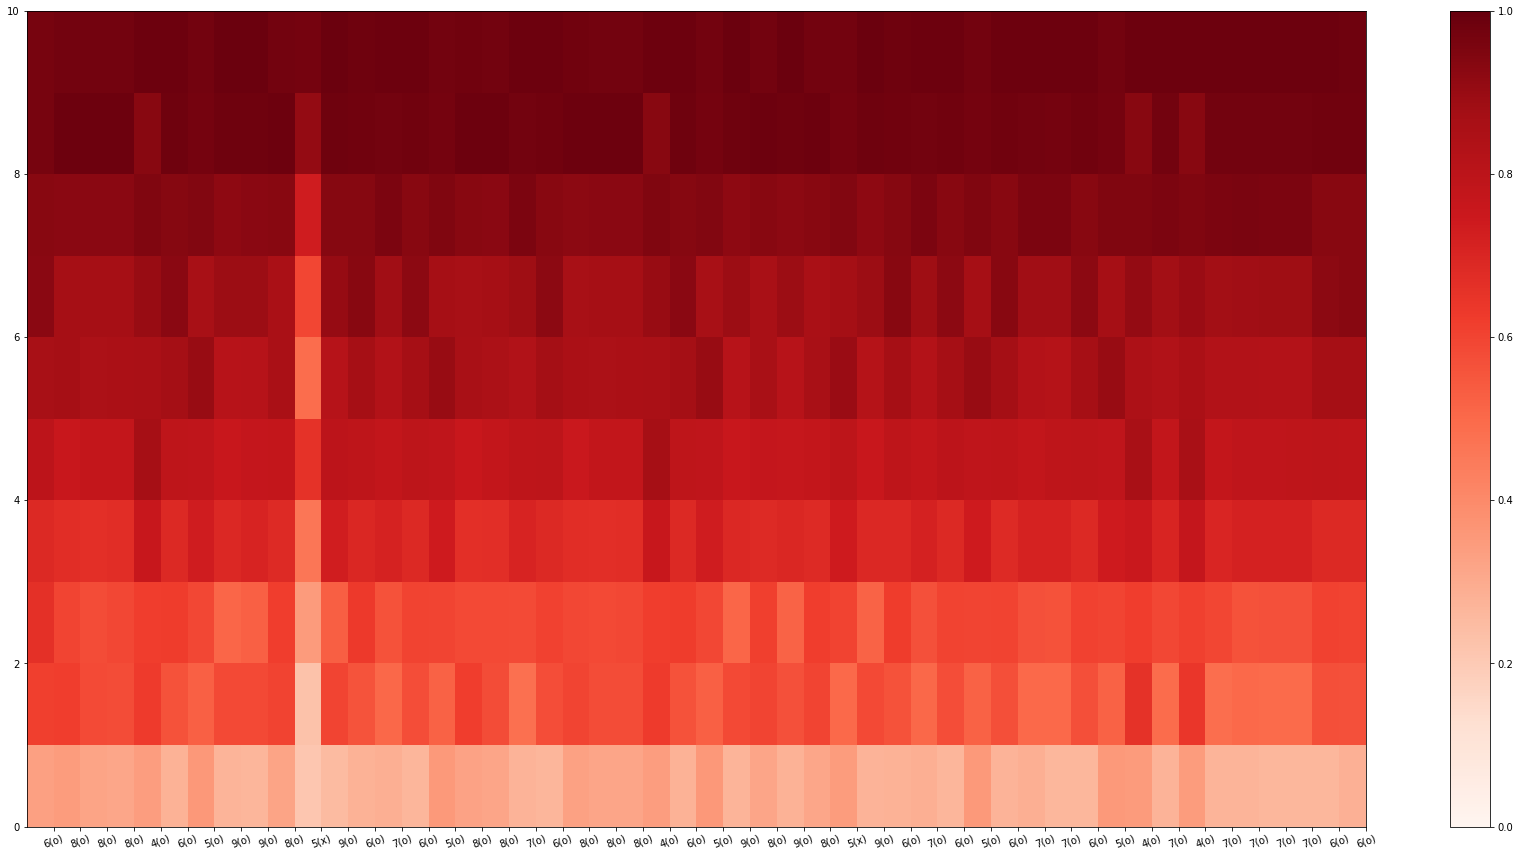

In [31]:
''' tech note '''
''' SAKT는 sigmoid값으로 나온 것들의 평균을 구한다음에 또 sigmoid를 씌어주면 interpretability가 좋음'''

# # #data preprocess for deep-learning model
# # #first, you need to decide the number of intervals to label the difficulty of problems
# df = preprocess_difficulty(10)
# q_seq, r_seq = q_seq_r_seq(df, "DKT")
# q_seq, r_seq, t_seq, d_seq, m_seq = match_seq_len("DKT", q_seq,r_seq)

# # # # # #next, run the model with selected model_name
# state  = run_model("DKT")

# # # #lastly get the user state for selected model
# # state = ".ckpts/dkt_model_new_aucs=0.80068872426278.ckpt"           #DKT
# # state = ".ckpts/sakt_model_new_aucs=0.8081135877355159.ckpt"        #SAKT
# # state = ".ckpts/dkt_model_new_aucs=0.8562268211472348.ckpt"         #DKVMN
# # state = ".ckpts/dkvmn_model_new_aucs=0.812243542740829.ckpt"        #DKVMN

# # state = ".ckpts/dkt_model_new_aucs=0.823621264433026.ckpt"
state = ".ckpts/dkt_model_new_aucs=0.8300560267397001.ckpt"

userseq = [468, 432]
for seq in userseq:
    user_state = prob_kc_target("DKT", seq, state)
    user_state = user_state.squeeze(1)
    print(user_state)
    solved_info = draw_user_state("DKT", seq, user_state)


# Expecti max algorithm

In [32]:
def user_action_state()

SyntaxError: invalid syntax (4251046262.py, line 1)

In [ ]:
def expect_score(model_name, state, previous_state, num_diff):
    
    # load the model 
    device = torch.device("cpu")
    with open(".datasets/q_list_{}.pkl".format(model_name), "rb") as f:
        q_list = pickle.load(f)
    if model_name == "SAKT":
        model = SAKT(len(q_list), 30, 100, 5, 0.2) 
    elif model_name == "DKVMN":
        model = DKVMN(len(q_list), 50, 50, 20)
    elif model_name == "DKT":
        model = DKT(200, len(q_list)) 
        
    response = [0,1]
    model.load_state_dict(torch.load(state, map_location = device))
    model.eval()
    expected_understanding = []

    #iterate through difficulty and return (difficulty, expectation_score) hashmap
    expect_score = {}
    correct = 1/(np.exp(-previous_state[q]) +1)
    wrong = 1-correct 
    for q in range(num_diff):
        # print("correct:", correct)
        # print("wrong:", wrong)
        correct_p, wrong_p = np.mean(np.array([p.detach().numpy() for p in model.get_knowledge_state(q, 1)])), \
            np.mean(np.array([p.detach().numpy() for p in model.get_knowledge_state(q, 0)]))
        # print("correct_p:", correct_p)
        # print("wrong_p:", wrong_p)
        score = correct * 1/(np.exp(-correct_p) + 1) + wrong * 1/(np.exp(-wrong_p) + 1)
        expect_score[q] = score
    return expect_score 

    


In [ ]:
state = ".ckpts/dkt_model_new_aucs=0.80068872426278.ckpt"  
seq = 432
user_state = (prob_kc_target("DKT", seq, state)).T




20
(20, 101)


In [ ]:
previous_state = user_state[:, -1]
ex_score = expect_score("DKT", state, user_state[:,-1], 5)
print(ex_score) 

{0: 0.6624587603453328, 1: 0.6675542564674468, 2: 0.6549601704823298, 3: 0.6536634922336857, 4: 0.6668139405436215}


# Random stuff

In [ ]:
question_category2 = pd.read_csv(".datasets/question_category2.csv", sep = '\t')
question = np.unique(question_category2["question_id"].values)
qc_hash = {}
for q in question:
    df_temp = question_category2[question_category2["question_id"] == q]
    qc_hash[q] = np.unique(df_temp["category2"].values)
with open(".datasets/question_difficulty_preprocess.pkl", "rb") as f:
    qd = pickle.load(f)
qdd = []
for k,v in qd.items():
    qd_temp = [k, v, qc_hash[k][0]]
    qdd += [qd_temp]
qdd = pd.DataFrame(qdd, columns = ['question_id', 'weight','category2'])

In [ ]:
category2_count = {}
category2 = np.unique(qdd["category2"].values)
for c in category2:
    category2_count[c] = len(qdd[qdd["category2"] == c])


In [ ]:
category2_count

{'01 다항식의 연산': 338,
 '01 집합의 뜻과 표현': 236,
 '02 집합의 연산': 319,
 '02 항등식과 나머지정리': 242,
 '03 명제': 335,
 '03 인수분해': 229,
 '04 복소수': 302,
 '04 함수': 349,
 '05 유리함수': 255,
 '05 이차방정식': 314,
 '06 무리함수': 194,
 '06 이차방정식과 이차함수': 269,
 '07 경우의 수와 순열': 218,
 '07 여러 가지 방정식': 340,
 '08 연립일차부등식': 216,
 '08 조합': 178,
 '09 이차부등식과 연립이차부등식': 310,
 '10 평면좌표': 233,
 '11 직선의 방정식': 283,
 '12 원의 방정식': 281,
 '13 도형의 이동': 249}